# Correlation between encryption time and count of set bits of key
The notebook aims to find a correlation between the time taken by the PRESENT algorithm for encryption and the number of set bits in the master key

## Import Essentials

In [1]:
import string 
import random
import time
import pandas as pd
import seaborn as sns
import binascii
import sys  
sys.path.insert(0, './present.py')
from present import Present

## Helper functions
We create two helper functions
- `encryptPresent(message, key)` for encrypting a message with given key. The function returns the time taken to encrypt the message in microseconds.
- r`andom_bits(word_size, bit_count)` which returns a random number with number of bits less than word_size and number of set bits equal to bit_count. 

In [2]:
def encrpytPresent(message,key):
    cipher = Present()
    cipher.setKey(key)
    cipher.setMessage(message)
    
    start = time.perf_counter_ns()
    out = cipher.encryption()
    end = time.perf_counter_ns()

    return (end-start)*(1e-6)

In [3]:
# gives a number with size less than 80 bits (word_size) and number of set bits (bit_count)
def random_bits(word_size, bit_count):
    number = 0
    for bit in random.sample(range(word_size), bit_count):
        number |= 1 << bit
    return number

## Correlation
We use `nm` random messages of 64 bit length. For each message, we generate `n` keys with number of set bits starting from 1 to 79 and store in elapsed time, set bit count and the key in dataframe `df`.

In [5]:
df = pd.DataFrame(columns=['key', 'high', 'time_elapsed_micro'])
text = string.ascii_uppercase + string.ascii_lowercase + string.digits + ' '

nm = 5 # number of messages
n = 100 # number of test cases per message
for t in range(nm):
    m = ''.join(random.choices(text, k = 8))   # message of 8 bytes for present
    print('message {}: {}'.format(t,m))
    for i in range(1,80):
        # generate 10 random keys with count of set bits as 'i'
        for j in range(n):
            key = random_bits(80,i) # number with 'i' set bits
            hex_key = hex(key).replace('0x','') # convert key to hex
            hex_key = (20-len(hex_key))*'0' + hex_key # append 0 to start to make the length 20 
            time_elapsed = encrpytPresent(m, hex_key)
            df.loc[df.shape[0]+1] = [hex_key, i ,time_elapsed]

message 0: qJEX5W21
message 1: 6a10O85Z
message 2: sVmJybYI
message 3: YfhRC CD
message 4: UXmAJJpP


In [6]:
df

,key,high,time_elapsed_micro
1,00000200000000000000,1,1.9849
2,00000004000000000000,1,2.1713
3,00080000000000000000,1,0.9011
4,00001000000000000000,1,2.3843
5,00000000000000000004,1,0.8890
...,...,...,...
39496,ffffffffffffffffffef,79,0.8852
39497,ffbfffffffffffffffff,79,0.8865
39498,fffffffffffffffdffff,79,0.9094
39499,fffffffffff7ffffffff,79,0.8819


## Write to csv
We store the data of `df` in `correlation_data.csv` 

In [7]:
df.to_csv('correlation_data.csv',index=False)

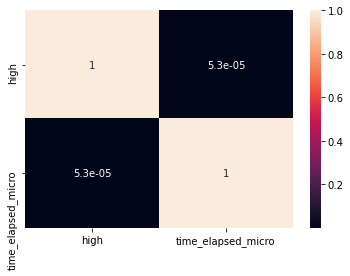

In [9]:
sns.heatmap(df.corr(),annot= True);

The above heatmap shows that there is nearly zero correlation between elapsed time and number of set bits.

## Visualization
Line plot of number of set bits vs average time elapsed.

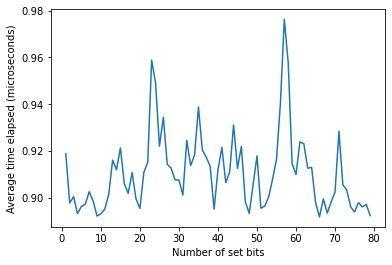

In [10]:
gp = df.groupby('high')
ax = sns.lineplot(x = gp.mean()['time_elapsed_micro'].keys(),y = gp.mean()['time_elapsed_micro'].values);
ax.set(xlabel="Number of set bits", ylabel = "Average time elapsed (microseconds)");